# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 6: *HTEllipseDecomposition*
Ellipse detection by the Hough transform decomposition
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, plotImageF, plotImageL, createScaleImageL, createImageF
from ImageOperatorsUtilities import applyCannyEdgeDetector
from ImagePropertiesUtilities import imageArgMax
from PlotUtilities import plot3DHistogram 

# Math and iteration
from math import sqrt, pi, sin, cos, tan
from random import randint
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    gaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    upperT = Upper threshold
    lowerT = Lower threshold
    axisRange = Possible axes size
    angleRange = Possible angles
    segmentLenghtThreshod = To remove small line segments. Percentage of larger segment
    pairsPerPoint = Number of pairs for each edge point

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter6/Input/")
imageName = "Cup.png"
gaussianKernelSize = 5
sobelKernelSize = 3
upperT = 0.3
lowerT = 0.2
axisRange = [20,60]  
angleRange = [0, 4]
segmentLenghtThreshod = 0.30
pairsPerPoint = 40

### Read and show input image

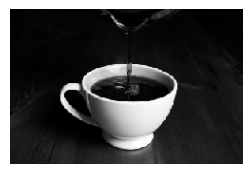

In [3]:
inputImage, width, height  = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 3)

### Compute edges

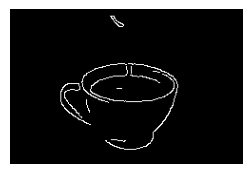

In [4]:
magnitude, angle = applyCannyEdgeDetector(inputImage, gaussianKernelSize, sobelKernelSize, upperT, lowerT)
plotImageF(magnitude, figureSize = 3)

### Find segments 

In [5]:
segmentsList = []
segmentsImage = createImageF(width, height)
maxSegmentLenght = 0
for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0 and segmentsImage[y,x] == 0:
        segment = [ ]
        segmentPoints = [(y,x)]
        segmentsImage[y,x] = 255
        while len(segmentPoints) > 0:
            yc = (segmentPoints[0])[0]
            xc = (segmentPoints[0])[1]
            segment.append((yc,xc))
            segmentPoints = segmentPoints[1:]
            
            for dx,dy in itertools.product(range(-1,2), range(-1,2)):
                xn, yn = xc+dx, yc+dy
                if dx!=0 or dy!=0 and xn > 0 and yn > 0 and xn < width and yn < height:
                    if magnitude[yn,xn] != 0 and segmentsImage[yn,xn] == 0:
                        segmentPoints.append((yn,xn))
                        segmentsImage[yn,xn] = 255
    
        segmentsList.append(segment)
        if len(segment) > maxSegmentLenght:
            maxSegmentLenght = len(segment)     

# Remove segments based on its size
# Segments can also be removed based on curvature or 
#  gather evidence for each segment to determine if it is part of an ellipse
segments = []
numSegments = len(segmentsList) 
for s in range(0, numSegments):    
    segment = segmentsList[s]
    numPoints = len(segment)
    if numPoints >= maxSegmentLenght * segmentLenghtThreshod:
        for p in range(0, numPoints):
            y = (segment[p])[0]
            x = (segment[p])[1]
            segments.append((y,x))

### Gather evidence

In [6]:
accumulator = createImageF(width, height) 
numPoints = len(segments)

# Sample points distance. Higher the eccentricity higher the distance so points give accurate positions
axisRatio = float(axisRange[1]) / (2.0*float(axisRange[0]))
deltaPointRange = [int(axisRatio*axisRange[0]), int(1.2*axisRange[1])]

# For a pair p1 = (x1,y1), p2=(x2,y2)
for p1 in range(0, numPoints):
    for p in range(0,pairsPerPoint):
        p2 = randint(0, numPoints-1)
        
        y1,x1 = (segments[p1])[0], (segments[p1])[1]
        y2,x2 = (segments[p2])[0], (segments[p2])[1]
        d = sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))
        if d > deltaPointRange[0]:  
            angle1, angle2 = -angle[y1,x1], -angle[y2,x2]
            
            # To void parallel edge directions
            w = cos(angle1)*cos(angle2) + sin(angle1)*sin(angle2) 
            if w < 0.9:
                xm, ym = (x1 + x2) / 2.0, (y1 + y2) / 2.0
                m1, m2 = tan(angle1), tan(angle2)
                A,B = y1-y2, x2-x1
                C,D = m1+m2, m1*m2 
                M,N = A*C+2*B*D, 2*A+B*C
                
                norm = sqrt(M*M+N*N)
                M,N = M/norm, N/norm
                # Draw horizontal or vertical lines
                if abs(M) < abs(N):
                    m = float(M) / float(N)
                    b1, b2 = y1-m1*x1, y2-m2*x2
                    xIntersect = (b2-b1)/ (m1-m2)
                    if xIntersect < xm: 
                        xi,xf = int(xm), min(int(xm + axisRange[1]), width-1)
                    else:               
                        xi,xf = max(1,int(xm - axisRange[1])), int(xm)
                    for x in range(xi,xf):
                        y = m *(x - xm) + ym
                        d1 = sqrt((x-x1)*(x-x1)+(y-y1)*(y-y1))
                        if d1 > axisRange[0] and d1 < axisRange[1]:
                            yInt = int(y)
                            if yInt > 0 and yInt < height -1:
                                weight = y - yInt
                                accumulator[yInt,   x] += (1.0 - weight) 
                                accumulator[yInt+1, x] += weight 
                    
                else:
                    m = float(N) / float(M)
                    b1, b2 = x1-m1*y1, x2-m2*y2  
                    yIntersect = (b2-b1) / (m1-m2)
                    if yIntersect < ym: 
                        yi,yf = int(ym), min(int(ym + axisRange[1]), height-1) 
                    else:               
                        yi,yf = max(1,int(ym - axisRange[1])), int(ym)
                    for y in range(yi,yf):
                        x = m *(y - ym) + xm
                        d1 = sqrt((x-x1)*(x-x1)+(y-y1)*(y-y1))
                        if d1 > axisRange[0] and d1 < axisRange[1]:
                            xInt = int(x)
                            if xInt > 0 and xInt < width -1:
                                weight = x - xInt
                                accumulator[y, xInt] += (1.0 - weight) 
                                accumulator[y, xInt+1] += weight     

### Find maximum and plot accumulator

78 124


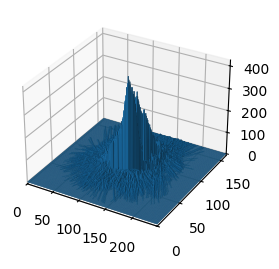

In [7]:
maximumPos = imageArgMax(accumulator)
#print(maximumPos[0], maximumPos[1])
plot3DHistogram(accumulator)

### Gather evidence axis parameters

In [8]:
angleSize = angleRange[1] - angleRange[0]
maxAxisSize = axisRange[1] - axisRange[0]
accumulatorAxis = createImageF(maxAxisSize, maxAxisSize, angleSize)
for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0:
        dx = x - maximumPos[1]
        dy = y - maximumPos[0]
        for r in range(0, angleSize):
            rot = ((r + angleRange[0]) * pi) / 180.0     
            for angle in range(0,360):   
                t = (angle * pi) / 180.0        
                A,B = cos(t)*cos(rot), sin(t)*sin(rot)  
                C,D = cos(t)*sin(rot), sin(t)*cos(rot)  
                Det  = A*D + C*B
                
                if Det != 0:
                    Detx, Dety = dx*D+dy*B, A*dy-C*dx
                    a, b = Detx/Det - axisRange[0], Dety/Det - axisRange[0]
                    aInt, bInt = int(a), int(b)
                    if aInt>0 and bInt>0 and aInt<maxAxisSize-2 and bInt<maxAxisSize-2    \
                              and bInt<aInt:
                        weightA, weightB = a-aInt, b-bInt       
                        accumulatorAxis[bInt, aInt,r] += (1.0-weightA) + (1.0-weightB)
                        accumulatorAxis[bInt, aInt+1,r] += weightA + (1.0-weightB)
                        accumulatorAxis[bInt+1,aInt,r] += (1.0-weightA) + weightB 
                        accumulatorAxis[bInt+1,aInt+1,r] += weightA + weightB

### Find maximum and plot accumulator

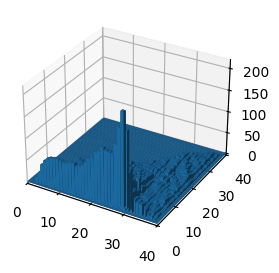

In [9]:
maximumAxis = imageArgMax(accumulatorAxis)
plot3DHistogram(accumulatorAxis[:, :, maximumAxis[2]])

### Draw ellipse on an output image

In [10]:
outputImage = createScaleImageL(inputImage, 0.5)

rotAngle = ((maximumAxis[2]+angleRange[0]) * pi) / 180.0  
a,b = maximumAxis[1]+axisRange[0], maximumAxis[0]+axisRange[0]
#print(a, b)
for m in range(0,360):
    angle = (m * pi) / 180.0
    x = int(maximumPos[1]+ a*cos(angle)*cos(rotAngle) - b*sin(angle)*sin(rotAngle))
    y = int(maximumPos[0]+ a*cos(angle)*sin(rotAngle) + b*sin(angle)*cos(rotAngle))
    if x<width and x>0 and y<height and y>0:
        outputImage[y,x] = 255

### Show image with detected ellipse 

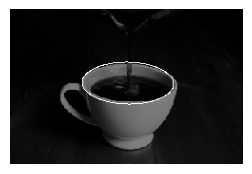

In [11]:
plotImageL(outputImage, figureSize = 3)